<a href="https://colab.research.google.com/github/rajeevrpandey/Transfer-Learning-on-tf_flowers/blob/main/Pretrained_Models_for_Transfer_Learning_on_tf_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import tensorflow_datasets as tfds
# Load the TF Flowers dataset, which consists of 5 flower categories
# `as_supervised=True` returns images and labels as tuples
# `with_info=True` provides metadata about the dataset
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
# Print dataset split information
info.splits

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [4]:
# Get training split details
info.splits["train"]


<SplitInfo num_examples=3670, num_shards=2>

In [5]:
# Get class names (flower categories)
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
# Get the total number of classes (flower types)
n_classes = info.features["label"].num_classes
n_classes

5

In [7]:
# Get the total number of images in the dataset
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [8]:
# Split dataset into training (75%), validation (15%), and test (10%)
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]",   # First 10% of the dataset → Test Set
           "train[10%:25%]",  # Next 15% of the dataset → Validation Set
           "train[25%:]"],   # Remaining 75% → Training Set
    as_supervised=True  # Returns a tuple (image, label) instead of dictionary format
)

In [9]:
def preprocess(image, label):
    # Resize the image to 224x224 pixels to match the Xception model input dimensions
    resized_image = tf.image.resize(image, [224, 224])
    # Normalize the image using Xception's predefined preprocessing function
    final_image = keras.applications.xception.preprocess_input(resized_image)
    # Return the processed image and its corresponding label
    return final_image, label

In [10]:
from functools import partial  # Import `partial` to pass fixed arguments to functions

# Define batch size for training, validation, and testing
batch_size = 32

# Prepare the Training Dataset

# Shuffle the training dataset with a buffer size of 1000 (ensures random sampling).
# `repeat()` makes the dataset repeat indefinitely, useful for training epochs.
train_set = train_set_raw.shuffle(1000).repeat()
# Apply the `preprocess` function to each image in the dataset.
# `partial(preprocess, randomize=True)` ensures that training images undergo:
  #  Random cropping (data augmentation)
  #  Random horizontal flipping (to improve generalization)
train_set = train_set.map(partial(preprocess))
# Group images into batches of `batch_size` (32 images per batch).
train_set = train_set.batch(batch_size)
# Prefetch 1 batch ahead of time to improve training performance.
train_set = train_set.prefetch(1)


# Prepare the Validation Dataset

# Apply the `preprocess` function (without randomization) to validation images.
valid_set = valid_set_raw.map(preprocess)
# Group validation images into batches of 32.
valid_set = valid_set.batch(batch_size)
# Prefetch 1 batch to ensure efficient data loading during validation.
valid_set = valid_set.prefetch(1)


# Prepare the Test Dataset

# Apply the same preprocessing steps as validation.
test_set = test_set_raw.map(preprocess)
# Group test images into batches of 32.
test_set = test_set.batch(batch_size)
# Prefetch 1 batch ahead for efficient testing.
test_set = test_set.prefetch(1)


In [11]:
# Load the Xception model pretrained on ImageNet.
# `weights="imagenet"`: Uses pretrained weights from ImageNet.
# `include_top=False`: Excludes the final classification layer, as we will add our own.
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

# Add Custom Layers on Top of the Pretrained Base Model

# Apply Global Average Pooling (GAP) to reduce the spatial dimensions of feature maps.
  #  Converts the feature maps into a single vector per image.
  #  Reduces overfitting compared to a fully connected (dense) layer.
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

# Define the final output layer with softmax activation for multi-class classification.
  #  `n_classes` represents the number of flower categories.
  #  Softmax activation ensures the output represents class probabilities.
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

# Create the Final Model

# Define the full model with:
  #  Input from the Xception model
  #  Pretrained convolutional layers as feature extractors
  #  Custom classification head (GAP + Dense layer with softmax)
model = keras.models.Model(inputs=base_model.input, outputs=output)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
# Print Layer Index and Names of the Pretrained Xception Model

for index, layer in enumerate(base_model.layers):
    print(index, layer.name)  # Output the layer index and its name


0 input_layer
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3

In [13]:

# Freeze the Pretrained Xception Layers (Feature Extractor)
for layer in base_model.layers:
    layer.trainable = False

# Define Learning Rate Schedule and Optimizer

# Use an exponential decay learning rate schedule.
  #  `initial_learning_rate=0.2`: High initial learning rate for training new layers.
  #  `decay_steps=1000`: Defines how often the learning rate is updated.
  #  `decay_rate=0.96`: Scales the learning rate by 0.96 after `decay_steps`.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.2,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True  # Reduces learning rate in discrete steps rather than smoothly
)

# Define the SGD optimizer with momentum and the learning rate schedule.
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


# Compile and Train the Model (Initial Training Phase)


# Compile the model with categorical cross-entropy loss and accuracy metric.
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Implement early stopping and Reduce learning rate when validation loss plateaus
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",      # Track validation loss
    patience=15,             # Stop after 15 epochs with no improvement
    restore_best_weights=True,  # Keep the best model weights
    min_delta=1e-4,          # Ignore small improvements
    verbose=1                # Display messages when stopping
)

# Train the model for 5 epochs with dataset configurations.
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5,
                    callbacks=[early_stopping],  # Apply early stopping
                    verbose=1)              # Print training progress)


Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step - accuracy: 0.6737 - loss: 2.2247 - val_accuracy: 0.8419 - val_loss: 1.3844
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.8942 - loss: 0.8077 - val_accuracy: 0.8419 - val_loss: 1.2106
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.9305 - loss: 0.3542 - val_accuracy: 0.8382 - val_loss: 1.1628
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9418 - loss: 0.2668 - val_accuracy: 0.8217 - val_loss: 1.6953
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.9355 - loss: 0.3610 - val_accuracy: 0.8511 - val_loss: 1.1734
Restoring model weights from the end of the best epoch: 3.


In [14]:
# Unfreeze the Base Model for Fine-Tuning
for layer in base_model.layers:
    layer.trainable = True

# Define Learning Rate Schedule and Optimizer

# Use an exponential decay learning rate schedule.
  #  `initial_learning_rate=0.01`: Starts with a low learning rate for fine-tuning.
  #  `decay_steps=1000`: Defines how frequently the learning rate is updated.
  #  `decay_rate=0.95`: Scales the learning rate by 0.95 after `decay_steps` steps.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True  # Reduces learning rate in discrete steps
)

# Define the SGD optimizer with Nesterov momentum and the learning rate schedule.
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)


# Compile and Train the Model (Fine-Tuning Phase)


# Compile the model with categorical cross-entropy loss and accuracy metric.
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Implement early stopping and Reduce learning rate when validation loss plateaus
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",      # Track validation loss
    patience=15,             # Stop after 15 epochs with no improvement
    restore_best_weights=True,  # Keep the best model weights
    min_delta=1e-4,          # Ignore small improvements
    verbose=1                # Display messages when stopping
)

# Train the model for 10 epochs, fine-tuning the base model layers.
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10,
                    callbacks=[early_stopping],  # Apply early stopping
                    verbose=1)              # Print training progress)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 80s 527ms/step - accuracy: 0.8335 - loss: 0.5927 - val_accuracy: 0.8254 - val_loss: 0.8558
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 473ms/step - accuracy: 0.9654 - loss: 0.1117 - val_accuracy: 0.8934 - val_loss: 0.3989
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 958ms/step - accuracy: 0.9897 - loss: 0.0440 - val_accuracy: 0.9099 - val_loss: 0.3103
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 489ms/step - accuracy: 0.9964 - loss: 0.0161 - val_accuracy: 0.8989 - val_loss: 0.3543
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step - accuracy: 0.9981 - loss: 0.0097 - val_accuracy: 0.9099 - val_loss: 0.3581
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.9967 - loss: 0.0085 - val_accuracy: 0.9191 - val_loss: 0.3592
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step - accuracy: 0.9955 - loss: 0.0088 - val_accuracy: 0.9191 - val_loss: 0.3575
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step - accuracy: 0.9972 - loss: 0.0132 - val_accu

In [15]:
# Evaluate the fine-tuned model on the test set
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step - accuracy: 0.9303 - loss: 0.3165
Test Accuracy: 92.92%
Test Loss: 0.2990


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


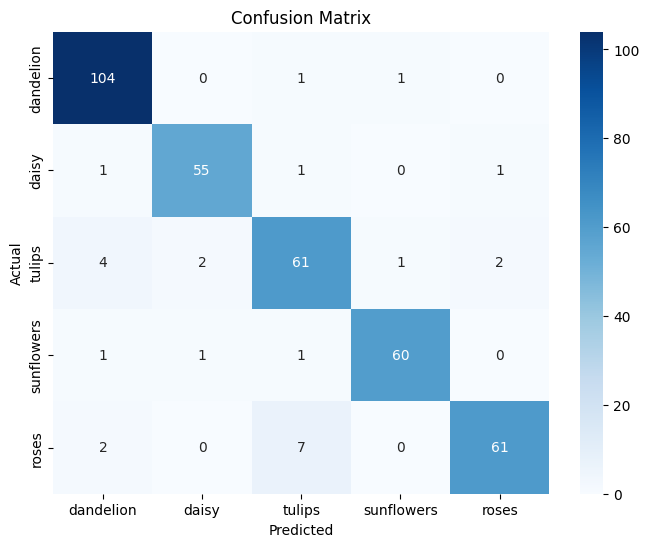

In [16]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions on the test dataset
y_true = []
y_pred = []

# Iterate through the test dataset
for images, labels in test_set:
    preds = model.predict(images)  # Get model predictions
    y_pred.extend(np.argmax(preds, axis=1))  # Convert probabilities to class indices
    y_true.extend(labels.numpy())  # Get actual class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [17]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

   dandelion       0.93      0.98      0.95       106
       daisy       0.95      0.95      0.95        58
      tulips       0.86      0.87      0.87        70
  sunflowers       0.97      0.95      0.96        63
       roses       0.95      0.87      0.91        70

    accuracy                           0.93       367
   macro avg       0.93      0.92      0.93       367
weighted avg       0.93      0.93      0.93       367



12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step


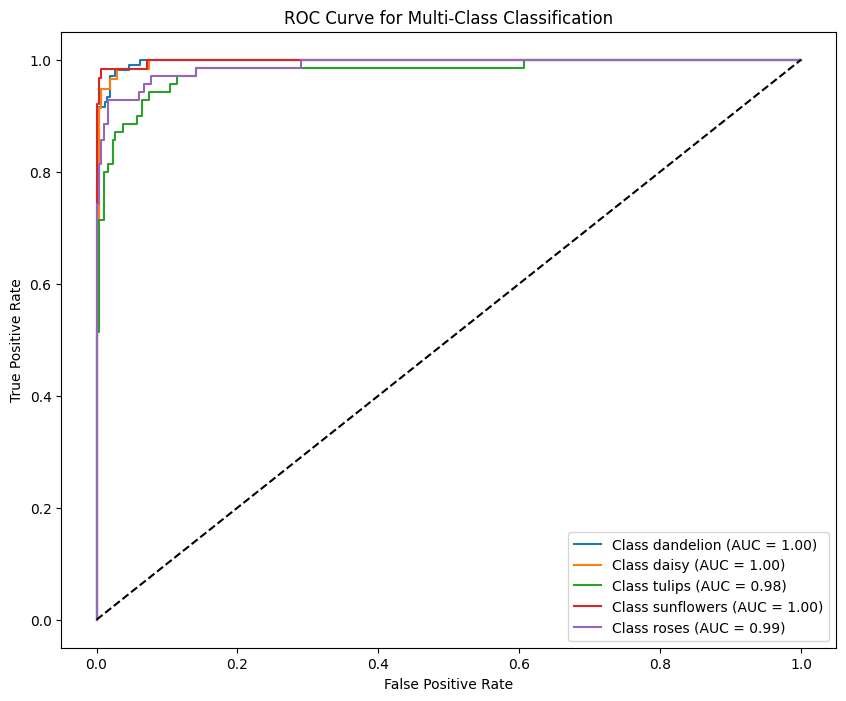

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
y_pred_prob = model.predict(test_set)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend()
plt.show()


From the provided ROC curve for multi-class classification, we can deduce the following about the model's performance:

**High Classification Performance:**

The model performs exceptionally well, as indicated by the high Area Under the Curve (AUC) values for all classes.
Most classes have an AUC of 1.00, meaning nearly perfect classification.
The lowest AUC observed is 0.98 for tulips, which is still very strong.

**Minimal False Positives & False Negatives:**

The ROC curve is very close to the top-left corner (ideal classifier).
This suggests the model achieves high sensitivity (true positive rate) and high specificity (low false positive rate).